# Evaluation of GRN inference methods
## Processing results
### by Jalil Nourisa



# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
import os
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import sys 
import numpy as np
import json
from scipy.stats import pearsonr
import seaborn
sys.path.insert(0, '../')
from src.helper import *

plt.rcParams['font.family'] = 'Liberation Sans'

results_folder = '../results_folder'
task_grn_inference_dir = '../../task_grn_inference'
scores_dir = '../../task_grn_inference/resources/scores'

datasets = ['op', 'replogle2', 'nakatake', 'norman', 'adamson']

%matplotlib inline

# Overview of performance

## Format resourcs used

In [2]:
if True: 
    # job_ids_dict_hvg = { 
    #     'portia': 7744548,
    #     'grnboost2': 7742249,
    #     'scenic': 7742283,
    #     'genie3': 7742285,
    #     'ppcor': 7742364,
    #     'scglue': 7742343,
    # }

    job_ids_dict = { 
        'portia': 7751292,
        'grnboost2': 7747906,
        'scenic': 7748219,
        'ppcor': 7748321,
        'scglue': [7756286, 7756675],
        'scenicplus': [7761874, 7760439, 7760554],
        'figr': 7756664,
        'celloracle': 7761872,
        'pearson_corr': 7770044,
        'positive_control': 7770047,
        'negative_control':7770048 
    }
    
    df_res = process_trace_local(job_ids_dict)
    df_res = df_res[['Elapsed', 'MaxVMSize']]
    granie = pd.DataFrame({'Elapsed':  3643.337/60/60, 'MaxVMSize': 41},index=['granie'])
    df_res = pd.concat([df_res, granie], axis=0)
    df_res.columns = ['Duration (hour)', 'Peak memory (GB)']


## Merge scores with resources

In [3]:
# - collect all the scores
for i, dataset in enumerate(datasets):
    df_scores = pd.read_csv(f"{task_grn_inference_dir}/resources/scores/{dataset}/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv", index_col=0)
    # - normalize scores 
    df_scores = df_scores.fillna(0)
    df_scores[df_scores < 0] = 0
    df_scores = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
    df_scores = df_scores.reset_index().melt(id_vars='index', var_name='metric', value_name='r2score').rename(columns={'index':'model'})
    df_scores['dataset'] = dataset
    if i == 0:
        df_all = df_scores
    else:
        df_all = pd.concat([df_all, df_scores], axis=0)
df_all = df_all[~(df_all['model'] == 'collectri')]
# - mean scores for metrics
def mean_for_metrics(df):
    metric = df['metric'].values.flatten()[0]
    if metric in ['S1','S2']:
        df = df[df['dataset']=='op']
    else:
        pass 
    return df[['r2score']].mean()
df_metrics = df_all.groupby(['model','metric']).apply(lambda df: mean_for_metrics(df)).reset_index().pivot(index='model', columns='metric', values='r2score')

# - mean scores for datasets
def mean_for_datasets(df):
    dataset = df['dataset'].values.flatten()[0]
    if dataset != 'op':
        df = df[~df['metric'].isin(['S1','S2'])]
    else:
        pass 
    return df[['r2score']].mean()
df_datasets = df_all.groupby(['model','dataset']).apply(lambda df: mean_for_datasets(df)).reset_index().pivot(index='model', columns='dataset', values='r2score')

## Calculate overal scores

In [4]:
# - calculate over scores
df_scores = pd.concat([df_metrics, df_datasets], axis=1)
# df_scores = df_metrics
df_scores['overall_score'] = df_scores.mean(axis=1)

# - merge scores with resources 
df_summary = pd.concat([df_scores, df_res], axis=1)
df_summary = df_summary.fillna(0)
df_summary.index.name = 'method_name' 
df_summary = df_summary.reset_index()

df_summary = df_summary.sort_values(by='overall_score', ascending=False) 

df_summary.method_name = df_summary.method_name.map(surragate_names)
# - add user complexity 
df_summary['User-friendly'] = df_summary['method_name'].map({
                            'Scenic+': 1, 
                            'GRNBoost2': 8, 
                            'Positive Control': 10, 
                            'Baseline Correlation': 10,
                            'CellOracle': 6,
                            'Portia': 9,
                            'scGLUE': 6,
                            'Scenic': 7,
                            'FigR': 6,
                            'PPCOR': 7,
                            'Negative Control': 10,
                            'GRaNIE': 6,
                            })
df_summary['Complexity'] = df_summary['User-friendly'].max() - df_summary['User-friendly']
df_summary.columns = [surragate_names.get(col, col) for col in df_summary.columns]

df_summary

,method_name,S11,S12,S21,S22,S23,Adamson,Nakatake,Norman,OPSCA,Replogle,overall_score,Duration (hour),Peak memory (GB),User-friendly,Complexity
3,GRNBoost2,1.000000,0.776475,0.826432,0.980936,1.000000,1.000000,0.787585,0.941155,0.925419,1.000000,0.923800,7.510556,7.378796,8,2
7,Positive Control,0.981252,1.000000,0.958346,0.860857,0.633513,0.832683,0.857764,0.886458,0.865377,0.729077,0.860533,0.015000,11.601669,10,0
10,Scenic+,0.800199,0.634004,0.913697,0.983595,0.888349,0.000000,0.000000,0.000000,0.843969,0.000000,0.843969,11.740556,131.342854,1,9
5,Baseline Correlation,0.775394,0.881858,0.880661,0.792117,0.556792,0.814796,0.729421,0.834992,0.718003,0.692485,0.767652,0.041389,23.801899,10,0
0,CellOracle,0.633710,0.641349,0.843619,0.773048,0.561766,0.000000,0.000000,0.000000,0.690699,0.000000,0.690699,3.765000,41.601166,6,4
6,Portia,0.632905,0.567038,0.523610,0.337081,0.235700,0.000000,0.511919,0.266277,0.527488,0.569957,0.417198,2.491111,55.685230,9,1
11,scGLUE,0.211603,0.571086,0.682864,0.316799,0.229125,0.000000,0.000000,0.000000,0.402295,0.000000,0.402295,11.097500,61.677879,6,4
9,Scenic,0.433522,0.392839,0.437852,0.350487,0.345024,0.000000,0.289197,0.240945,0.606671,0.245343,0.371320,24.008611,35.954300,7,3
1,FigR,0.305938,0.449542,0.252149,0.345278,0.265239,0.000000,0.000000,0.000000,0.323629,0.000000,0.323629,6.731667,225.208725,6,4
8,PPCOR,0.267408,0.200610,0.360093,0.285175,0.165767,0.566048,0.041881,0.418685,0.268351,0.033865,0.260788,13.425833,64.136433,7,3


## Summary figure

In [5]:
summary_file = f"{results_folder}/summary.tsv"
summary_figure = f"{results_folder}/summary_figure.pdf"

df_summary['memory_log'] = np.log(df_summary['Peak memory (GB)']+1)
df_summary['memory_log'] = np.max(df_summary['memory_log'])-df_summary['memory_log']

df_summary['complexity_log'] = np.log(df_summary['Complexity']+1)
df_summary['complexity_log'] = np.max(df_summary['complexity_log'])-df_summary['complexity_log']

df_summary["duration_log"] = np.log(df_summary['Duration (hour)']+1)
df_summary['duration_log'] = np.max(df_summary['duration_log'])-df_summary['duration_log']

df_summary["duration_str"] = df_summary['Duration (hour)'].round(1).astype(str)
df_summary['memory_str'] =  df_summary['Peak memory (GB)'].round(1).astype(str)

df_summary.to_csv(summary_file, sep='\t')

!Rscript ../src/summary_figure.R {summary_file} {summary_figure}

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.5.1     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.3.1     ✔ stringr 1.5.1
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
`thisfile()` was deprecated in rprojroot 2.0.0.
ℹ Please use `whereami::thisfile()` instead. 
New names:
• `` -> `...1`
Rows: 12 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): method_name
dbl (21): ...1, S11, S12, S21, S22, S23, Adamson, Nakatake, Norman, OPSCA, R...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
ℹ Could not find column 'id' in data. Using rownames as 'id'.
ℹ Column info did not contain a column call

# Scores

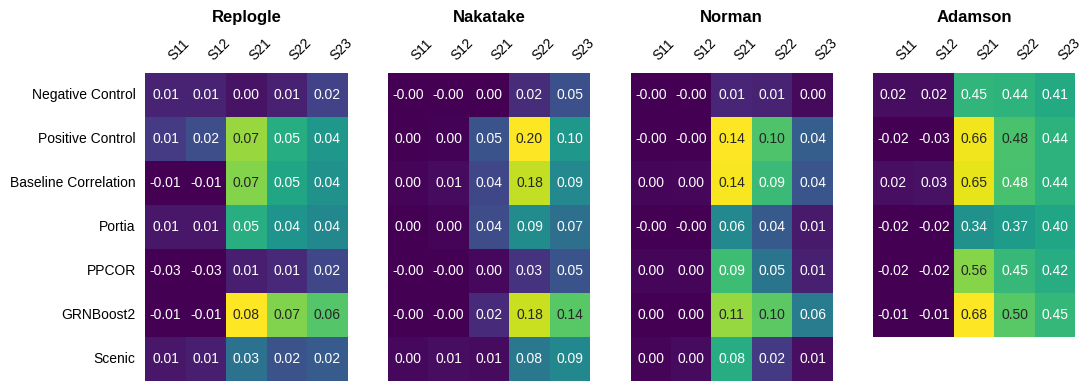

In [6]:
# - raw scores for all datasets - ridge
fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharey=True)
for i, dataset in enumerate(datasets[1:]):
    scores_mat = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv', index_col=0)

    if 'scenic' not in scores_mat.index:
        scores_mat.loc['scenic',:] = np.nan
    scores_mat.columns = scores_mat.columns.map(surragate_names)
    scores_mat.index = scores_mat.index.map(surragate_names)



    ax = axes[i]
    plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
    ax.set_title(f'{surragate_names[dataset]}', pad=10, fontsize=12, fontweight='bold')
    
# fig.suptitle(f'Evaluation scores', y=1.1, fontsize=12, fontweight='bold')
fig.savefig(f"{results_folder}/benchmark/figs/evaluation_scores_other_datasets.png", dpi=300, transparent=True, bbox_inches='tight')

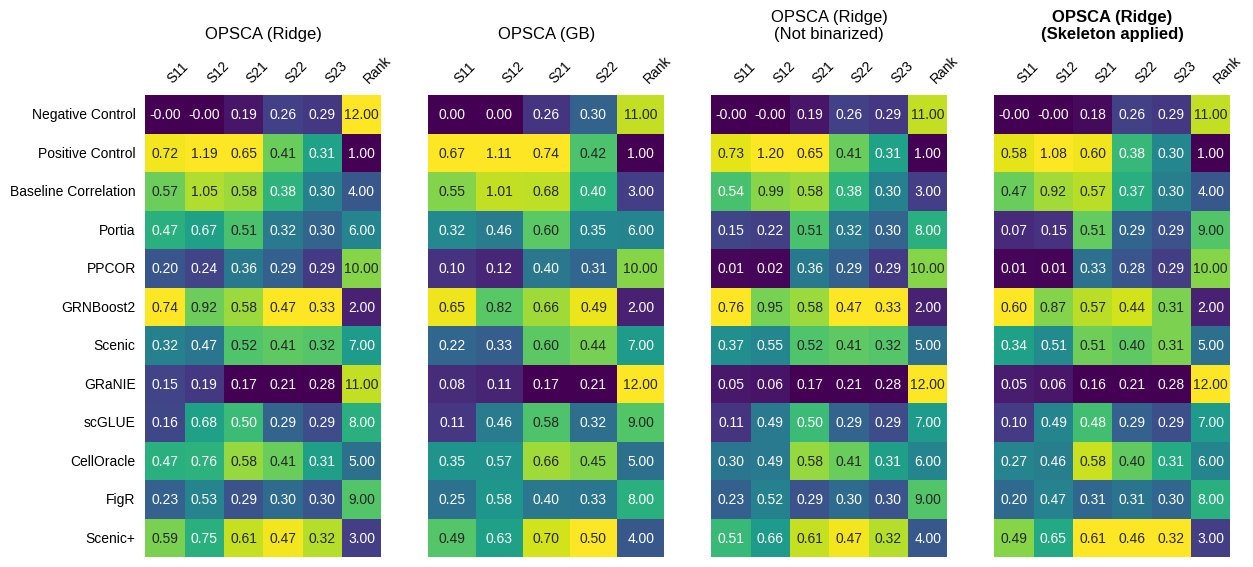

In [7]:
def plot_heatmap(scores, ax=None, name='', fmt='0.02f', cmap="viridis"):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=True)

    # Normalize each column individually
    scores_normalized = scores.apply(lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x)), axis=0)

    # Define the color scale range for each column (0 to 1 after normalization)
    vmin = 0
    vmax = 1

    # Plot the heatmap with normalized scores
    seaborn.heatmap(scores_normalized, ax=ax, square=False, cbar=False, annot=True, fmt=fmt, vmin=vmin, vmax=vmax, cmap=cmap)
    # Overlay the original (unnormalized) scores as annotations
    for text, value in zip(ax.texts, scores.values.flatten()):
        text.set_text(f'{value:.2f}')  # Formatting the annotation text to show the unnormalized value

    # Customize the axes and title
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    ax.set_title(name, pad=10)

    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')
    
fig, axes = plt.subplots(1, 4, figsize=(14, 6), sharey=True)
dataset = 'op'
for i, reg_type in enumerate(['ridge', 'GB']):
    scores_mat = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-{reg_type}-global-False.csv', index_col=0)
    if 'collectri' in scores_mat.index:
        scores_mat = scores_mat.drop('collectri')
    scores_mat.columns = scores_mat.columns.map(surragate_names)
    scores_mat.index = scores_mat.index.map(surragate_names)
    scores_rank = scores_mat.div(scores_mat.max(axis=0), axis=1).sum(axis=1)
    scores_mat['Rank'] = scores_rank.rank(ascending=False)

    ax = axes[i]
    plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
    ax.set_title(f"{surragate_names[dataset]} ({reg_type.capitalize() if not reg_type.isupper() else reg_type})", pad=10, fontsize=12)

scores_mat = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_False-ridge-global-False.csv', index_col=0)
scores_mat.columns = scores_mat.columns.map(surragate_names)
scores_mat.index = scores_mat.index.map(surragate_names)
scores_rank = scores_mat.div(scores_mat.max(axis=0), axis=1).sum(axis=1)
scores_mat['Rank'] = scores_rank.rank(ascending=False)

ax = axes[2]
plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
ax.set_title(f"{surragate_names[dataset]} (Ridge)\n(Not binarized)", pad=10, fontsize=12)

scores_mat = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_True-binarize_False-ridge-global-False.csv', index_col=0)
scores_mat.columns = scores_mat.columns.map(surragate_names)
scores_mat.index = scores_mat.index.map(surragate_names)

scores_rank = scores_mat.div(scores_mat.max(axis=0), axis=1).sum(axis=1)
scores_mat['Rank'] = scores_rank.rank(ascending=False)

ax = axes[3]
plot_heatmap(scores_mat, name='SLA normalization', ax=ax, cmap="viridis")
ax.set_title(f"{surragate_names[dataset]} (Ridge)\n(Skeleton applied)", pad=10, fontsize=12, fontweight='bold')
# fig.suptitle('(A) Regression scores (ridge)', y=1.2, fontsize=12, fontweight='bold')
fig.savefig(f"{results_folder}/benchmark/figs/evaluation_scores_opsca.png", dpi=300, transparent=True, bbox_inches='tight')

In [16]:
1800/20000

0.09

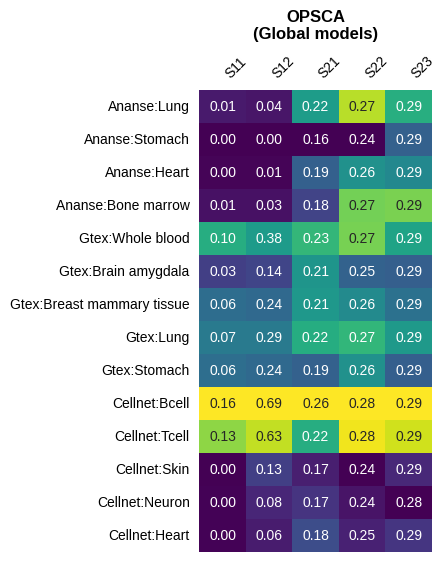

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(3, 6), sharey=False)
dataset='op'
ax = axes
scores_mat = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-ridge-global-True.csv', index_col=0)
scores_mat.columns = scores_mat.columns.map(surragate_names)
# scores_mat.index = scores_mat.index.map(surragate_names)


plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
ax.set_title(f"{surragate_names[dataset]}\n(Global models)", pad=10, fontsize=12, fontweight='bold')
fig.savefig(f"{results_folder}/benchmark/figs/evaluation_scores_global_models.png", dpi=300, transparent=True, bbox_inches='tight')

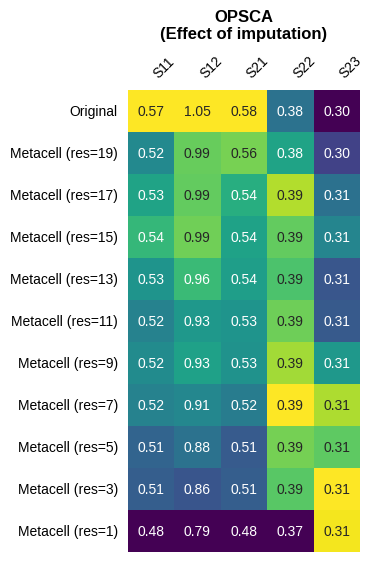

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(3, 6), sharey=False)

scores_mat = pd.read_csv(f'{task_grn_inference_dir}/output/metacells/scores_all.csv', index_col=0)
scores_mat.columns = scores_mat.columns.map(surragate_names)
scores_mat.index = scores_mat.index.map(lambda name: 'Original' if name == -1 else f'Metacell (res={name})')

index_oder = ['Original'] + [f'Metacell (res={name})' for name in range(19, 0, -2)]

scores_mat = scores_mat.reindex(index=index_oder)
plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
ax.set_title(f"{surragate_names[dataset]}\n(Effect of imputation)", pad=10, fontsize=12, fontweight='bold')
fig.savefig(f"{results_folder}/benchmark/figs/evaluation_scores_imputation.png", dpi=300, transparent=True, bbox_inches='tight')

In [10]:
scores_mat_sub

NameError: name 'scores_mat_sub' is not defined

In [26]:
scores_mat_sub

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0
type,,,,,
causal,NaN,NaN,0.580583,0.379891,0.303594
corr,NaN,NaN,0.530924,0.310279,0.294974


Text(0.5, 1.1, 'Metrics performance ')

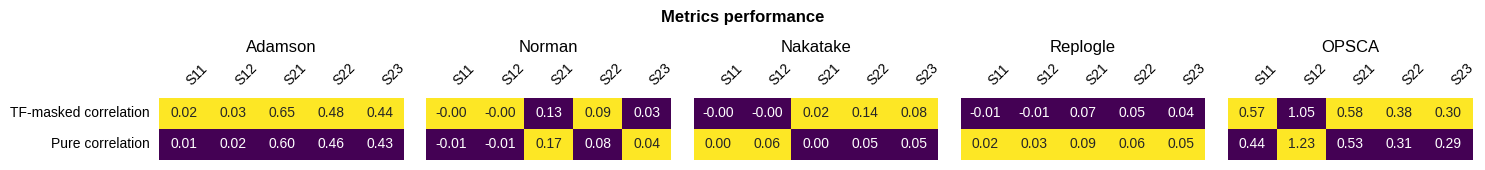

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(15, 1.5), sharey=True)

scores_mat = pd.read_csv(f'{task_grn_inference_dir}/output/causal_vs_corr/scores_all.csv', index_col=0)
scores_mat.columns = scores_mat.columns.map(lambda name: surragate_names.get(name,name))
scores_mat['type'] = scores_mat['type'].map(lambda name: {'causal':'TF-masked correlation', 'corr':'Pure correlation'}.get(name,name))

for i, dataset in enumerate(scores_mat.dataset.unique()):
    ax = axes[i]
    scores_mat_sub = scores_mat[scores_mat.dataset==dataset].drop(columns='dataset')
    scores_mat_sub = scores_mat_sub.set_index(['type'])

    plot_heatmap(scores_mat_sub, name='', ax=ax, cmap="viridis")
    ax.set_title(surragate_names.get(dataset,dataset))
    # ax.tick_params(axis='y', rotation=0)  # Set x-axis labels horizontal
    ax.set_ylabel('')  # Remove x-axis label
    # if i == 0:
    #     ax.xaxis.tick_top()  # Show x-axis ticks at the top for the first plot
    #     # ax.tick_params(axis='x', rotation=0)  # Set x-axis labels horizontal
    # else:
    #     ax.set_xticks([])
plt.tight_layout()
plt.suptitle(f"Metrics performance ", y=1.1, fontsize=12, fontweight='bold')
# fig.savefig(f"{results_folder}/benchmark/figs/evaluation_scores_imputation.png", dpi=300, transparent=True, bbox_inches='tight')

# Robustness analysis

In [11]:
def format_robustness_results(base_dir, noise_type='net'):
    degrees = [0, 10, 20, 50, 100]
    reg1_metric = 'S1'
    reg2_metric = 'static-theta-0.5'
    for i, degree in enumerate(degrees):
        df = pd.read_csv(f'{base_dir}/{noise_type}-{degree}-scores.csv',index_col=0)
        df_reg1 = df.loc[:, [reg1_metric]].rename(columns={reg1_metric:degree})
        df_reg2 = df.loc[:, [reg2_metric]].rename(columns={reg2_metric:degree})
        
        if i == 0:
            reg1_scores = df_reg1
            reg2_scores = df_reg2
        else:
            reg1_scores = pd.concat([reg1_scores, df_reg1], axis=1)
            reg2_scores = pd.concat([reg2_scores, df_reg2], axis=1)
        
    reg1_scores = reg1_scores.T
    reg2_scores = reg2_scores.T
    return reg1_scores, reg2_scores

In [12]:
!ls ../../task_grn_inference/resources/results/robustness_analysis

net-0-scores.csv    sign-100-scores.csv  weight-100-scores.csv
net-100-scores.csv  sign-10-scores.csv	 weight-10-scores.csv
net-10-scores.csv   sign-20-scores.csv	 weight-20-scores.csv
net-20-scores.csv   sign-50-scores.csv	 weight-50-scores.csv
net-50-scores.csv   tmp
sign-0-scores.csv   weight-0-scores.csv


In [13]:
base_dir = '../../task_grn_inference/resources/results/robustness_analysis'
figsize=(3.5, 3)

In [14]:
noise_type = 'net'
reg1_mat_net, reg2_mat_net = format_robustness_results(base_dir, noise_type=noise_type)
noise_type = 'sign'
reg1_mat_sign, reg2_mat_sign = format_robustness_results(base_dir, noise_type=noise_type)
noise_type = 'weight'
reg1_mat_weight, reg2_mat_weight = format_robustness_results(base_dir, noise_type=noise_type)


/vol/tmp/users/jnourisa/ipykernel_1450621/1411286234.py:29: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  g = sns.catplot(
/vol/tmp/users/jnourisa/ipykernel_1450621/1411286234.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/vol/tmp/users/jnourisa/ipykernel_1450621/1411286234.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/vol/tmp/users/jnourisa/ipykernel_1450621/1411286234.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/vol/tmp/users/jnourisa/ipykernel_1450621/1411286234.py:29:

<Figure size 1000x600 with 0 Axes>

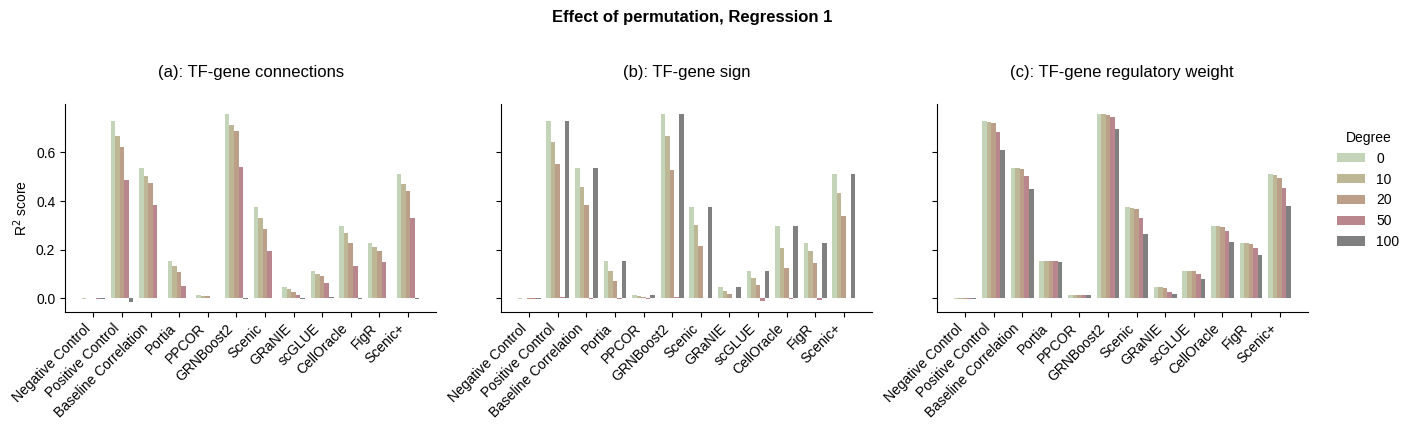

<Figure size 1000x600 with 0 Axes>

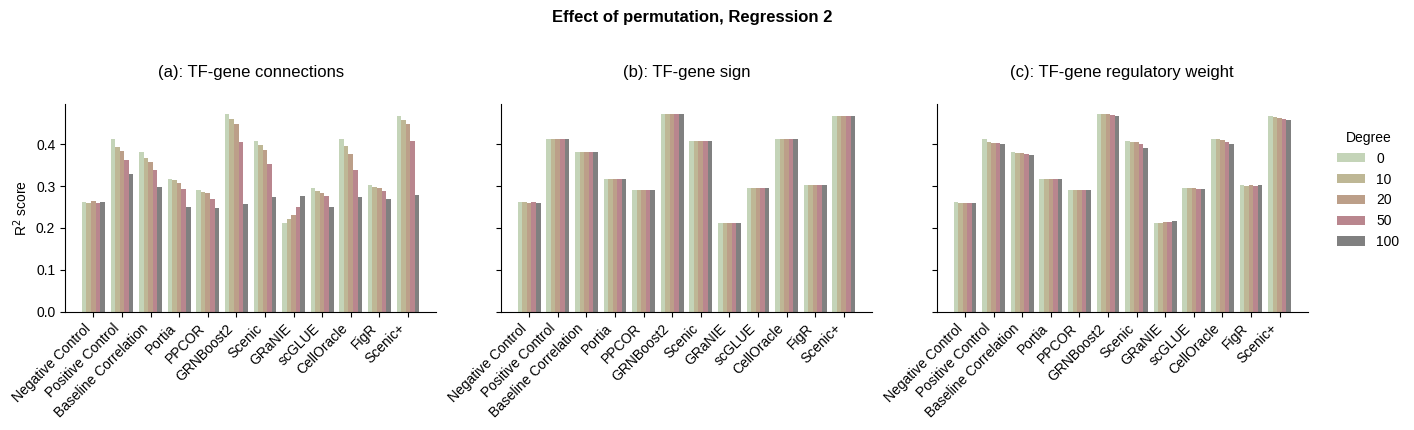

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_robustness(reg_mat_net, reg_mat_sign, reg_mat_weight, title):
    reg_mat_net['Permute type'] = 'TF-gene connections'
    reg_mat_sign['Permute type'] = 'TF-gene sign'
    reg_mat_weight['Permute type'] = 'TF-gene regulatory weight'


    # Concatenate the DataFrames
    df_concat = pd.concat([reg_mat_net, reg_mat_sign, reg_mat_weight])
    
    df_concat.columns = df_concat.columns.map(lambda name: surragate_names.get(name, name))
    # print(df_concat)

    # Reset the index so that noise degree remains a column
    df_concat.reset_index(inplace=True, drop=False)
    df_concat.rename(columns={'index': 'Degree'}, inplace=True)

    df_melt = pd.melt(df_concat, id_vars=['Degree', 'Permute type'], 
                    var_name='method', value_name=r'R$^2$ score')

    df_melt = df_melt[df_melt.method!='Degree']

    plt.figure(figsize=(10, 6))

    # Create a bar plot where noise types are nested within methods
    g = sns.catplot(
        data=df_melt, 
        x='method', 
        y=r'R$^2$ score', 
        hue='Degree', 
        col='Permute type', 
        kind='bar',
        height=3, 
        # width=6, 
        aspect=1.4,
        palette=colors_cell_type,
        legend_out=True
    )

    # Rotate the x-axis labels for all subplots
    for ax in g.axes.flatten():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_xlabel('')
    # Adjust the position of the legend to the right
    g._legend.remove()
    g.add_legend(title="Degree", bbox_to_anchor=(.95, 0.6), loc='center left')
    prefixes = ['(a)', '(b)', '(c)']
    for i, ax in enumerate(g.axes.flat):
        sub_title = ax.get_title().replace('Permute type = ', f'{prefixes[i]}: ').strip()  # Remove 'Type='
        ax.set_title(sub_title, pad=20, fontsize=12)

        ax.margins(x=0.05)
    plt.suptitle(title, y=1.2,  fontsize=12, fontweight='bold')
plot_robustness(reg1_mat_net, reg1_mat_sign, reg1_mat_weight, 'Effect of permutation, Regression 1')
plt.savefig(f"{results_folder}/benchmark/figs/robustness_reg1.png", dpi=300, transparent=True, bbox_inches='tight')
plot_robustness(reg2_mat_net, reg2_mat_sign, reg2_mat_weight, 'Effect of permutation, Regression 2')
plt.savefig(f"{results_folder}/benchmark/figs/robustness_reg2.png", dpi=300, transparent=True, bbox_inches='tight')
